### Read transformed data

In [19]:
import pandas as pd

df_clean = pd.read_csv("atp_transformed/2000-2024_clean.csv")

C:\Users\jesse\AppData\Local\Temp\ipykernel_20652\2898197302.py:3: DtypeWarning: Columns (5,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_clean = pd.read_csv("atp_transformed/2000-2024_clean.csv")


In [20]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1285138 entries, 0 to 1285137
Data columns (total 38 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   tourney_id               1285138 non-null  object 
 1   tourney_name             1285138 non-null  object 
 2   tourney_type             1285138 non-null  object 
 3   surface                  1285138 non-null  object 
 4   draw_size                1285138 non-null  int64  
 5   tourney_level            1285138 non-null  object 
 6   tourney_date             1285138 non-null  object 
 7   match_num                1285138 non-null  int64  
 8   score                    1285138 non-null  object 
 9   round_1                  1285069 non-null  object 
 10  round_2                  1279787 non-null  object 
 11  round_3                  432103 non-null   object 
 12  round_4                  24979 non-null    object 
 13  round_5                  6832 non-null    

In [3]:
unique_players = df_clean['player_id'].nunique()
print(f"Number of unique players: {unique_players}")

Number of unique players: 18639


In [4]:
# Convert tourney_date to datetime
df_clean['tourney_date_datetime'] = pd.to_datetime(df_clean['tourney_date'])

# Extract year
df_clean['year'] = df_clean['tourney_date_datetime'].dt.year

In [5]:
player_year_rank = (
    df_clean.groupby(['player_id', 'year'])['player_rank']
      .mean().round(2)
      .reset_index()
      .rename(columns={'player_rank': 'avg_rank_year'})
)

In [6]:
# Compute each player's average rank from 2018–2023
avg_rank_fixed_5yrs = (
    df_clean.query("2018 <= year <= 2023")
    .groupby('player_id')['player_rank']
    .mean().round(2)
    .reset_index()
    .rename(columns={'player_rank': 'avg_rank_prev_5yrs'})
)

# Merge back to assign this fixed average to all years
df_clean = df_clean.merge(avg_rank_fixed_5yrs, on='player_id', how='left')

In [7]:
player_year_rank['rank_change'] = (
    player_year_rank
    .sort_values(['player_id', 'year'])
    .groupby('player_id')['avg_rank_year']
    .diff(periods=-1)  # or diff(periods=1), depending on direction you prefer
                       # A negative change means improvement (rank number decreased, better ranking).
                       # A positive change means decline (rank number increased).
)


In [8]:
df_clean = df_clean.merge(player_year_rank, on=['player_id', 'year'], how='left')

In [9]:
years_with_nan = df_clean[df_clean['rank_change'].isna()]['year'].unique()
print("Years with rank_change NaN:", years_with_nan)


Years with rank_change NaN: [2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024]


In [10]:
# Group by year and check if all rank_change are NaN
years_only_nan = df_clean.groupby('year')['rank_change'].apply(lambda x: x.isna().all())

# Filter years where the result is True
years_only_nan = years_only_nan[years_only_nan].index.tolist()

print("Years where all rank_change values are NaN:", years_only_nan)


Years where all rank_change values are NaN: [2024]


# Rafael Nadal example:

In [11]:
nadal = df_clean[df_clean["player_name"] == "Rafael Nadal"]
nadal_per_year = (nadal[nadal['rank_change'].notna()].sort_values(by='year', ascending=False))  # Rank change does work, Nadal was lower ranked in 2024
nadal_sorted = nadal_per_year.drop_duplicates(subset=['year'], keep='first')

nadal_sorted[['player_id', 'player_name', 'avg_rank_year', 'rank_change', 'avg_rank_prev_5yrs', 'year']]

,player_id,player_name,avg_rank_year,rank_change,avg_rank_prev_5yrs,year
1159630,104745,Rafael Nadal,2.00,-398.90,2.3,2023
1102125,104745,Rafael Nadal,4.29,2.29,2.3,2022
1058461,104745,Rafael Nadal,2.72,-1.57,2.3,2021
1039380,104745,Rafael Nadal,1.68,-1.04,2.3,2020
983863,104745,Rafael Nadal,1.88,0.20,2.3,2019
924738,104745,Rafael Nadal,1.10,-0.78,2.3,2018
862909,104745,Rafael Nadal,4.27,3.17,2.3,2017
797888,104745,Rafael Nadal,4.95,0.68,2.3,2016
735666,104745,Rafael Nadal,6.21,1.26,2.3,2015
675435,104745,Rafael Nadal,1.18,-5.03,2.3,2014


# 2023 example

In [12]:
# keep only rows where rank_change is not NaN
df_sorted = (df_clean[df_clean['rank_change'].notna()].sort_values(by=['year', 'player_rank', 'player_id'], ascending=[False, True, True]))
df_sorted = df_sorted.drop_duplicates(subset=['player_id'], keep='first')

df_sorted[['player_id', 'player_name', 'avg_rank_year', 'rank_change', 'avg_rank_prev_5yrs', 'year']].head(20)


,player_id,player_name,avg_rank_year,rank_change,avg_rank_prev_5yrs,year
1160322,104925,Novak Djokovic,2.29,0.52,3.68,2023
1160628,207989,Carlos Alcaraz,1.58,-1.02,118.00,2023
1159242,104745,Rafael Nadal,2.00,-398.90,2.30,2023
1161904,106421,Daniil Medvedev,4.72,0.33,13.42,2023
1160040,126774,Stefanos Tsitsipas,4.92,-5.24,13.47,2023
1159258,134770,Casper Ruud,4.92,-3.68,51.22,2023
1163978,206173,Jannik Sinner,9.02,7.13,172.56,2023
1163568,208029,Holger Rune,7.34,-4.49,239.29,2023
1160086,126094,Andrey Rublev,6.40,-0.16,24.59,2023
1160260,126203,Taylor Fritz,8.56,-2.37,34.02,2023


In [13]:
# Find the index of the lowest rank for each player
idx = df_sorted.groupby('player_id')['player_rank'].idxmin()

# Map peak_age back into the dataframe
peak_age_map = df_sorted.loc[idx, ['player_id', 'player_age']]

df_sorted = df_sorted.merge(peak_age_map, on='player_id', how='left', suffixes=('', '_peak'))

df_sorted.rename(columns={'player_age_peak': 'peak_age'}, inplace=True)


In [14]:
df_sorted[['player_id', 'player_name', 'avg_rank_year', 'rank_change', 'avg_rank_prev_5yrs', 'peak_age', 'year']].head(20)

,player_id,player_name,avg_rank_year,rank_change,avg_rank_prev_5yrs,peak_age,year
0,104925,Novak Djokovic,2.29,0.52,3.68,36.0,2023
1,207989,Carlos Alcaraz,1.58,-1.02,118.00,20.0,2023
2,104745,Rafael Nadal,2.00,-398.90,2.30,36.0,2023
3,106421,Daniil Medvedev,4.72,0.33,13.42,27.0,2023
4,126774,Stefanos Tsitsipas,4.92,-5.24,13.47,24.0,2023
5,134770,Casper Ruud,4.92,-3.68,51.22,24.0,2023
6,206173,Jannik Sinner,9.02,7.13,172.56,22.0,2023
7,208029,Holger Rune,7.34,-4.49,239.29,20.0,2023
8,126094,Andrey Rublev,6.40,-0.16,24.59,25.0,2023
9,126203,Taylor Fritz,8.56,-2.37,34.02,25.0,2023


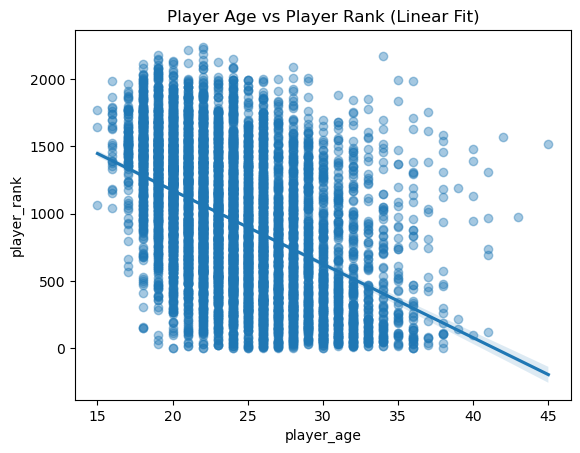

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import numpy as np
from statsmodels.stats.diagnostic import linear_reset

df_sorted = df_sorted[
    df_sorted['player_age'].replace([np.inf, -np.inf], np.nan).notna() &
    df_sorted['player_rank'].replace([np.inf, -np.inf], np.nan).notna()
]

# Scatterplot with regression line helps visually inspect 
# whether the relationship between age and rank is linear.
sns.regplot(
    data=df_sorted, 
    x='player_age', 
    y='player_rank', 
    scatter_kws={'alpha':0.4}  # transparency for readability
)
plt.title("Player Age vs Player Rank (Linear Fit)")
plt.show()


In [16]:
# Pearson → tests linear correlation
pearson_corr, pearson_p = stats.pearsonr(
    df_sorted['player_age'], 
    df_sorted['player_rank']
)

# Spearman → correlation of ranked values (monotonic relationship)
spearman_corr, spearman_p = stats.spearmanr(
    df_sorted['player_age'], 
    df_sorted['player_rank']
)

print("Pearson correlation:", pearson_corr, "p =", pearson_p)
print("Spearman correlation:", spearman_corr, "p =", spearman_p)

# Interpretation:
# - Correlation close to 0 → weak relationship
# - Negative correlation → better ranking at younger ages
# - p < 0.05 → the relationship is statistically significant


Pearson correlation: -0.46079452594928993 p = 0.0
Spearman correlation: -0.4801938875092125 p = 0.0


In [17]:
# Build a simple linear regression model: rank ~ age
X = sm.add_constant(df_sorted['player_age'])
y = df_sorted['player_rank']

model = sm.OLS(y, X).fit()

# RESET test checks if we are missing nonlinear terms
reset_test = linear_reset(model, use_f=True)
print(reset_test)

# Interpretation:
# - If p-value < 0.05 → Nonlinearity exists (linear model not appropriate)
# - If p-value > 0.05 → Linear model is acceptable


<F test: F=105.85409780898135, p=4.63573562227001e-46, df_denom=7.49e+03, df_num=2>


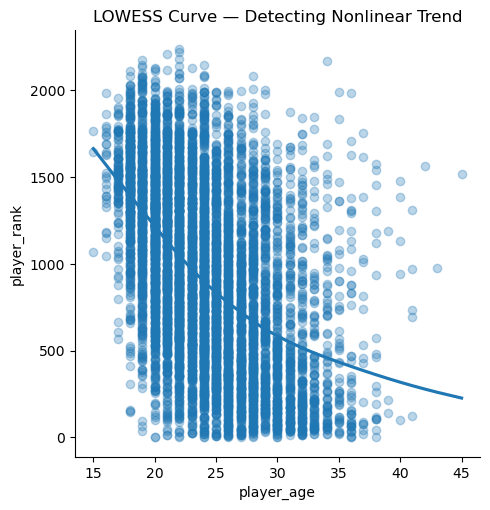

In [18]:
# LOWESS (Locally Weighted Regression) shows smooth nonlinear patterns
sns.lmplot(
    data=df_sorted, 
    x="player_age", 
    y="player_rank",
    lowess=True,
    scatter_kws={'alpha':0.3}
)
plt.title("LOWESS Curve — Detecting Nonlinear Trend")
plt.show()

# If the LOWESS curve bends strongly → nonlinear relationship.
